In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import progressbar
import warnings
warnings.filterwarnings('ignore')

# 1.0 Introduction
竞赛背景

太阳能被看作是最具有代表性的新能源，而其中太阳辐射是影响太阳能发电量的最主要因素。由于收到包括地理位置、太阳高度角、方位角、时角等时空要素，云量、云态、大气状态等气象要素的影响，太阳辐射预测一直是光伏发电量预测的关键。通过数值天气预报系统，可以通过对中尺度系统的模拟得到较为精细的辐射预报数据，然而预测信息中仍然存在冗余信息，单独使用辐射数据并不能精确地预报实际太阳辐射。



主办方简介：

  北京国能日新系统控制技术有限公司（简称：国能日新）是一家专业提供新能源软件产品及服务的高新技术企业，其拥有多项专业资质，具备自主研发、生产制造和全方位营销等综合能力，专注于为新能源企业在并网自动化、生产运营、企业信息化等方面提供优质的解决方案。通过专业的技术产品及全面的服务体系为新能源企业的更优发展提供技术保障。
  
### Mission
通过学习一段时间内的环境数据和对应的实际太阳辐指数，训练模型，通过给定某时间点预测的环境数据，预测该时间点的实际太阳辐射指数。
 
### Evalutaion
<img src="img/eval.png",width=270,height=60>
其中，n为样本数量， Pmi为实际太阳辐射指数；Ppi为预测太阳辐射指数。 

# 2.0 Data
- train_feature.csv 训练集特征数据，每个时刻1个数据，每天8个时刻。共17008。
- train_label.csv 训练集标签数据，每天1个数据，共2126个数据。
- test_feature.csv 测试集特征数据，每个时刻1个数据，每天8个时刻，共7320条数据，字段与训练集特征数据相同。

In [2]:
train_feature_df = pd.read_csv('train_feature.csv', low_memory=False)
train_label_df = pd.read_csv('train_label.csv', low_memory=False)
test_feature_df = pd.read_csv('test_feature.csv', low_memory=False)
print(train_feature_df.shape, train_label_df.shape, test_feature_df.shape)

(17008, 8) (2126, 2) (7320, 8)


In [7]:
train_feature_df[8:16]

,日期,时刻,辐照度,风速,风向,温度,湿度,气压
8,2,2,0,1.1,45,-5.2,46,69800
9,2,5,0,1.2,114,-5.8,52,69600
10,2,8,0,0.2,297,-8.9,59,69700
11,2,11,328,0.8,277,-3.9,41,69700
12,2,14,543,1.2,90,0.1,32,69400
13,2,17,198,1.4,69,1.2,30,69200
14,2,20,0,1.0,294,-3.8,45,69400
15,2,23,0,2.5,297,-5.4,48,69500


## 2.1 remake the data for each day
should be 7*8+2=58 cols

In [3]:
train_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = train_feature_df[train_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    train_feature_df_list.append(temp_df )

In [4]:
for i in range(8):
    train_label_df = train_label_df.merge(train_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))
train_label_df.head()

,日期,电场实际太阳辐射指数,时刻_2,辐照度_2,风速_2,风向_2,温度_2,湿度_2,气压_2,时刻_5,...,温度_20,湿度_20,气压_20,时刻_23,辐照度_23,风速_23,风向_23,温度_23,湿度_23,气压_23
0,1,0.108799,2,0,2.1,343,-7.2,51,69800,5,...,-3.5,40,69700,23,0,0.8,14,-4.8,42,69700
1,2,0.130559,2,0,1.1,45,-5.2,46,69800,5,...,-3.8,45,69400,23,0,2.5,297,-5.4,48,69500
2,3,0.114239,2,0,2.9,278,-7.4,58,69500,5,...,-3.8,30,69500,23,0,0.8,140,-3.8,29,69500
3,4,0.081599,2,0,0.3,90,-6.1,38,69500,5,...,-3.0,21,69100,23,0,0.8,270,-6.3,26,69200
4,5,0.212158,2,0,1.4,231,-9.9,33,69100,5,...,-6.1,26,69200,23,0,1.1,63,-7.5,28,69300


# 3.0  Model XGBoosting

## 3.1 normalize data

In [5]:
fcol = [c for c in train_label_df.columns if c not in ['日期', '时刻_2', '时刻_5', '时刻_8', '时刻_11', '时刻_14',
                                             '时刻_17', '时刻_20', '时刻_23','辐照度_2', '辐照度_5','辐照度_23', '电场实际太阳辐射指数']]

X = train_label_df[fcol].values
y = train_label_df['电场实际太阳辐射指数']

In [6]:
# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

## 3.2 parameter analysis of XGBoosting

### 3.2.1 n_estimator
The number of trees (or rounds) in an XGBoost model is specified to the XGBClassifier or XGBRegressor class in the n_estimators argument. The default in the XGBoost library is 100

Best: -0.169155 using {'n_estimators': 100}
-0.169155 (0.008189) with: {'n_estimators': 100}
-0.172410 (0.008316) with: {'n_estimators': 200}
-0.175598 (0.008421) with: {'n_estimators': 300}
-0.178515 (0.008089) with: {'n_estimators': 400}
-0.181137 (0.007610) with: {'n_estimators': 500}
-0.183211 (0.007527) with: {'n_estimators': 600}
-0.185103 (0.007517) with: {'n_estimators': 700}
-0.186353 (0.007157) with: {'n_estimators': 800}
-0.187526 (0.007107) with: {'n_estimators': 900}
-0.188602 (0.007292) with: {'n_estimators': 1000}
-0.189500 (0.007393) with: {'n_estimators': 1100}
-0.190309 (0.007367) with: {'n_estimators': 1200}
-0.191008 (0.007422) with: {'n_estimators': 1300}
-0.191721 (0.007441) with: {'n_estimators': 1400}


Text(0,0.5,'Log Loss')

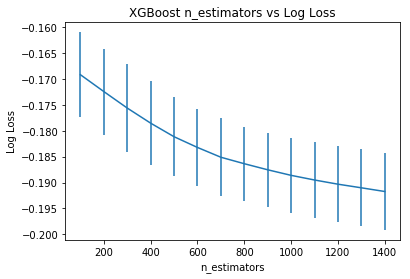

In [7]:
model = XGBRegressor()
n_estimators = range(100, 1500, 100)
param_grid = dict(n_estimators=n_estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')

### 3.2.2 max_depth
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.

range(1, 11, 2)
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.2s finished


Best: -0.169155 using {'max_depth': 3}
-0.171310 (0.008271) with: {'max_depth': 1}
-0.169155 (0.008189) with: {'max_depth': 3}
-0.175675 (0.008120) with: {'max_depth': 5}
-0.185003 (0.007988) with: {'max_depth': 7}
-0.191209 (0.008810) with: {'max_depth': 9}


Text(0,0.5,'Log Loss')

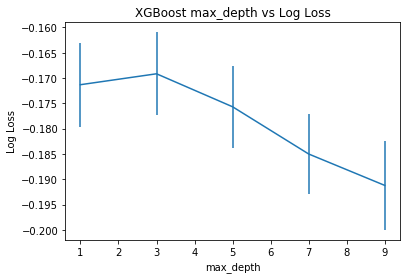

In [11]:
model = XGBRegressor()
max_depth = range(1, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(max_depth, means, yerr=stds)
pyplot.title("XGBoost max_depth vs Log Loss")
pyplot.xlabel('max_depth')
pyplot.ylabel('Log Loss')

### 3.2.3 the two

[2, 4, 6, 8]
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   46.5s finished


Best: -0.167258 using {'n_estimators': 100, 'max_depth': 2}
-0.167744 (0.008439) with: {'n_estimators': 50, 'max_depth': 2}
-0.167258 (0.008478) with: {'n_estimators': 100, 'max_depth': 2}
-0.167934 (0.008340) with: {'n_estimators': 150, 'max_depth': 2}
-0.168593 (0.007975) with: {'n_estimators': 200, 'max_depth': 2}
-0.169927 (0.007246) with: {'n_estimators': 50, 'max_depth': 4}
-0.172685 (0.007074) with: {'n_estimators': 100, 'max_depth': 4}
-0.175839 (0.006877) with: {'n_estimators': 150, 'max_depth': 4}
-0.177959 (0.007110) with: {'n_estimators': 200, 'max_depth': 4}
-0.175927 (0.008675) with: {'n_estimators': 50, 'max_depth': 6}
-0.180953 (0.008377) with: {'n_estimators': 100, 'max_depth': 6}
-0.184852 (0.008517) with: {'n_estimators': 150, 'max_depth': 6}
-0.188073 (0.008375) with: {'n_estimators': 200, 'max_depth': 6}
-0.183630 (0.007805) with: {'n_estimators': 50, 'max_depth': 8}
-0.188363 (0.007988) with: {'n_estimators': 100, 'max_depth': 8}
-0.191452 (0.007968) with: {'n_est

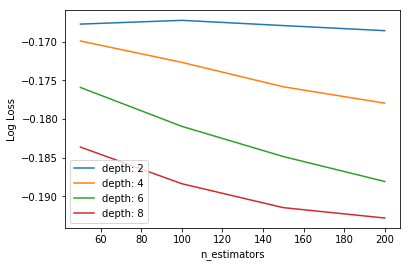

In [15]:
model = XGBRegressor()
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth.png')

### 3.2.4 with eta (learning rate)

In [54]:
model = XGBRegressor()
eta = np.array([0.1,0.01,0.001])
n_estimators = [50, 100, 150]
max_depth = [2, 3, 4]
param_grid = dict(learning_rate=eta, max_depth=max_depth, n_estimators=n_estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   39.6s finished


Best: -0.167258 using {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1}
-0.167744 (0.008439) with: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
-0.167258 (0.008478) with: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1}
-0.167934 (0.008340) with: {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.1}
-0.167716 (0.008365) with: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
-0.169155 (0.008189) with: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
-0.170581 (0.008231) with: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}
-0.169927 (0.007246) with: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1}
-0.172685 (0.007074) with: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
-0.175839 (0.006877) with: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}
-0.191075 (0.011083) with: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.01}
-0.180207 (0.010510) with: {'n_estimators': 100, 'm

## 3.3 train & predict

In [49]:
## xgboost training
xgb_up = xgboost.XGBRegressor(n_jobs=4,
                       n_estimators=100,
                       max_depth=2,
                       objective='binary:logistic',
                       min_child_weight=1,
                       tree_method='gpu_hist',
                       silent= True)
xgb_up.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [38]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: np.random.randint(0, 255), range(3)))
    return color

df = pd.DataFrame({'imp': xgb_up.feature_importances_, 'col':fcol})
df = df.sort_values(['imp','col'], ascending=[True, False])
data = [df]
for dd in data:  
    colors = []
    for i in range(len(dd)):
         colors.append(generate_color())
    data = [
        go.Bar(
        orientation = 'h',
        x=dd.imp,
        y=dd.col,
        name='Features',
        textfont=dict(size=20),
            marker=dict(
            color= colors,
            line=dict(
                color='#000000',
                width=0.5
            ),
            opacity = 0.87
        )
    )
    ]
    layout= go.Layout(
        title= 'Feature Importance of XGBOOST',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis=dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )

    py.iplot(dict(data=data,layout=layout), filename='horizontal-bar')

# Test Dataset

In [26]:
test_feature_df = test_feature_df.iloc[0:7296]
print('dates in test dataset is : ', test_feature_df.shape[0]/8)

dates in test dataset is :  912.0


In [27]:
# initalize the test label
index = np.arange(912)
columns = ['日期']
data = np.array([np.arange(1, 913)]).T
test_label_df = pd.DataFrame(data, index=index, columns=columns)

In [28]:
test_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = test_feature_df[test_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    test_feature_df_list.append(temp_df )
    
for i in range(8):
    test_label_df = test_label_df.merge(test_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))

In [29]:
test_label_df.head()

,日期,时刻_2,辐照度_2,风速_2,风向_2,温度_2,湿度_2,气压_2,时刻_5,辐照度_5,...,温度_20,湿度_20,气压_20,时刻_23,辐照度_23,风速_23,风向_23,温度_23,湿度_23,气压_23
0,1,2,0,1.3,257,-8.6,34,68600,5,0,...,-6.3,19,68900,23,0,14.9,286,-8.7,21,69100
1,2,2,0,13.8,288,-10.7,28,69300,5,0,...,-6.8,16,69400,23,0,11.6,280,-9.4,20,69600
2,3,2,0,9.6,274,-12.1,24,69700,5,0,...,-4.1,9,69800,23,0,12.1,281,-7.0,11,70000
3,4,2,0,7.5,278,-10.3,15,70000,5,0,...,-3.9,14,69500,23,0,3.3,272,-6.1,20,69500
4,5,2,0,5.1,276,-8.1,16,69600,5,0,...,-1.0,20,68700,23,0,1.6,333,-2.9,24,68700


### prediction

In [30]:
x_test = test_label_df[fcol].values
x_test = 1 - ((maxs - x_test) / rng)
x_test.shape

(912, 45)

In [36]:
predict = xgb_up.predict(x_test)

### make submission

In [37]:
data = np.array([np.arange(1, 913)]).T
submission_df = pd.DataFrame(data, index=index, columns=columns)
submission_df['prediction'] = predict
submission_df.rename(columns={'日期':'time'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)

### 2018/10/26 Error analysis
- xgb_up = XGBClassifier(n_jobs=4,n_estimators=300,max_depth=3,eta=0.15)
- score former 100 : 0.145                     
- part of the predictions are good, parts are extremely bad --- overlapping ??

### 2018/10/26 Error analysis 2
- xgb_up = XGBClassifier(n_jobs=4,n_estimators=500,max_depth=5,eta=0.15,objective='binary:logistic',min_child_weight=4,predictor='gpu_predictor',silent= True)
- score former 100 : 0.3
- wind of 8 and 2 become more important feature than before (radio 11 7 was more important)
### the problem is that I used a classifier               

### 2018/10/27 Score
- xgb_up = xgboost.XGBRegressor(n_jobs=4,n_estimators=100,max_depth=2,learning_rate=0.1,
objective='binary:logistic',min_child_weight=1,tree_method='gpu_hist',silent= True)
- score 0.19
- seems better